# Reto MA2003B - Calidad del Aire y Contaminantes ZMM
- Gabriel Villanueva de Araujo Souza - A01781585
- Hildegard Zerrweck García - A00838300
- Julio Chárbel Porras Osorio - A01736268

In [2]:
# Librerias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import yeojohnson, kstest, norm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# LIMPIEZA

## Compilación Datos no Limpios

In [3]:

base = Path("/Users/gabrielvas/Desktop/Aplicacion_metodosmultivariados_Reto")
stations = ["CENTRO", "NORTE", "SUROESTE", "SUROESTE2", "SURESTE3", "NORESTE2", "NORTE2"]
year_files = {
    2022: base / "DATOS_HISTORICOS_2022.xlsx",
    2023: base / "DATOS_HISTORICOS_2023.xlsx",
    2024: base / "DATOS_HISTORICOS_2024.xlsx",
    2025: base / "DATOS_HISTORICOS_2025.xlsx",
}

raw_series = {station: [] for station in stations}

columns_to_drop = ['RAINF', 'RH', 'PRS']

for year, file in year_files.items():
    yearly_raw = pd.read_excel(file, sheet_name=stations)  # sin limpieza
    for station in stations:
        df_station = yearly_raw[station].copy()
        # Eliminar columnas 'RAINF', 'RH', 'PRS' si existen
        df_station = df_station #.drop(columns=[col for col in columns_to_drop if col in df_station.columns], errors='ignore')
        df_station["date"] = pd.to_datetime(df_station["date"])
        df_station = df_station.set_index("date").sort_index()
        df_station["year"] = year           # opcional, ayuda a rastrear el origen
        raw_series[station].append(df_station)

df_por_estacion = {
    station: pd.concat(raw_series[station], axis=0)
    for station in stations
}

globals().update({
    f"df_{station}_22_25_nolimpio": df_por_estacion[station]
    for station in stations
})

# Ejemplo de verificación
for station in stations:
    print(station, df_por_estacion[station].shape)

CENTRO (30646, 16)
NORTE (30644, 16)
SUROESTE (30504, 16)
SUROESTE2 (30643, 16)
SURESTE3 (30643, 16)
NORESTE2 (30643, 16)
NORTE2 (30644, 16)


## Datos Limpios

### 2022

In [4]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2022.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 8),
    "NO": (0, 400),
    "NO2": (0, 175),
    "NOX": (0, 420),
    "O3": (0, 160),
    "PM10": (0, 999),
    "PM2.5": (0, 450),
    "SO2": (0, 200),
    "SR": (0, 1.25),
    "TOUT": (-5, 45),
    "WSR": (0, 35),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2022_{name}"] = temp_df

    print(f"Listo: df_2022_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2022_CENTRO creado (shape=(8760, 11))
Listo: df_2022_NORTE creado (shape=(8760, 11))
Listo: df_2022_SUROESTE creado (shape=(8760, 11))
Listo: df_2022_SUROESTE2 creado (shape=(8760, 11))
Listo: df_2022_SURESTE3 creado (shape=(8760, 11))
Listo: df_2022_NORESTE2 creado (shape=(8760, 11))
Listo: df_2022_NORTE2 creado (shape=(8760, 11))

--- PROCESO COMPLETO ---


### 2023

In [5]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2023.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 14),
    "NO": (0, 500),
    "NO2": (0, 175),
    "NOX": (0, 500),
    "O3": (0, 175),
    "PM10": (0, 900),
    "PM2.5": (0, 800),
    "SO2": (0, 250),
    "SR": (0, 1),
    "TOUT": (0, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2023_{name}"] = temp_df

    print(f"Listo: df_2023_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2023_CENTRO creado (shape=(8758, 11))
Listo: df_2023_NORTE creado (shape=(8758, 11))
Listo: df_2023_SUROESTE creado (shape=(8758, 11))
Listo: df_2023_SUROESTE2 creado (shape=(8758, 11))
Listo: df_2023_SURESTE3 creado (shape=(8758, 11))
Listo: df_2023_NORESTE2 creado (shape=(8758, 11))
Listo: df_2023_NORTE2 creado (shape=(8758, 11))

--- PROCESO COMPLETO ---


### 2024

In [6]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2024.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 18),
    "NO": (0, 400),
    "NO2": (0, 130),
    "NOX": (0, 500),
    "O3": (0, 180),
    "PM10": (0, 999),
    "PM2.5": (0, 999),
    "SO2": (0, 150),
    "SR": (0, 1.26),
    "TOUT": (-4, 45.5),
    "WSR": (0, 38),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2024_{name}"] = temp_df

    print(f"Listo: df_2024_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2024_CENTRO creado (shape=(8784, 11))
Listo: df_2024_NORTE creado (shape=(8782, 11))
Listo: df_2024_SUROESTE creado (shape=(8784, 11))
Listo: df_2024_SUROESTE2 creado (shape=(8782, 11))
Listo: df_2024_SURESTE3 creado (shape=(8782, 11))
Listo: df_2024_NORESTE2 creado (shape=(8782, 11))
Listo: df_2024_NORTE2 creado (shape=(8782, 11))

--- PROCESO COMPLETO ---


### 2025

In [7]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2025.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 10),
    "NO": (0, 350),
    "NO2": (0, 175),
    "NOX": (0, 400),
    "O3": (0, 185),
    "PM10": (0, 820),
    "PM2.5": (0, 350),
    "SO2": (0, 405),
    "SR": (0, 1.2),
    "TOUT": (-4.5, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2025_{name}"] = temp_df

    print(f"Listo: df_2025_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")

Listo: df_2025_CENTRO creado (shape=(4344, 11))
Listo: df_2025_NORTE creado (shape=(4344, 11))
Listo: df_2025_SUROESTE creado (shape=(4202, 11))
Listo: df_2025_SUROESTE2 creado (shape=(4343, 11))
Listo: df_2025_SURESTE3 creado (shape=(4343, 11))
Listo: df_2025_NORESTE2 creado (shape=(4343, 11))
Listo: df_2025_NORTE2 creado (shape=(4344, 11))

--- PROCESO COMPLETO ---


### Compilación Datos Limpiados

In [8]:
# Concatenar DataFrames por estación a través de 2022–2025

pattern = re.compile(r"^df_(2022|2023|2024|2025)_(.+)$")

frames_by_station: dict[str, list[tuple[int, pd.DataFrame]]] = {}
# Importante: iterar sobre una copia estática de globals() para evitar
# "RuntimeError: dictionary changed size during iteration"
for var_name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        m = pattern.match(var_name)
        if m:
            year = int(m.group(1))
            station = m.group(2)
            frames_by_station.setdefault(station, []).append((year, obj))

combined_by_station: dict[str, pd.DataFrame] = {}
for station, items in frames_by_station.items():
    # Ordenar por año
    items_sorted = sorted(items, key=lambda x: x[0])
    frames = [df for _, df in items_sorted]

    # Alinear columnas (unión en el primer orden encontrado)
    ordered_union_cols: list[str] = []
    seen_cols: set[str] = set()
    for df in frames:
        for c in df.columns:
            if c not in seen_cols:
                seen_cols.add(c)
                ordered_union_cols.append(c)

    aligned_frames = [df.reindex(columns=ordered_union_cols) for df in frames]
    combined_df = pd.concat(aligned_frames, sort=False)
    combined_df = combined_df.sort_index()

    var_name = f"df_{station}_22_25"  # Nota: guiones no válidos en nombres de variables
    globals()[var_name] = combined_df
    combined_by_station[station] = combined_df

    print(f"Creado {var_name}: shape={combined_df.shape} | años={[y for y, _ in items_sorted]}")

   # # Guardar el DataFrame combinado a CSV
   # try:
   #     combined_df.to_csv(f"{var_name}.csv")
   #     print(f" → Guardado como {var_name}.csv")
   # except Exception as e:
   #     print(f"Error al guardar {var_name}.csv:", e)

# Acceso también vía diccionario
df_22_25_by_station = combined_by_station
print(f"\nEstaciones combinadas: {list(df_22_25_by_station.keys())}")


Creado df_CENTRO_22_25: shape=(30646, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORTE_22_25: shape=(30644, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE_22_25: shape=(30504, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE2_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SURESTE3_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORESTE2_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORTE2_22_25: shape=(30644, 11) | años=[2022, 2023, 2024, 2025]

Estaciones combinadas: ['CENTRO', 'NORTE', 'SUROESTE', 'SUROESTE2', 'SURESTE3', 'NORESTE2', 'NORTE2']


# ANÁLISIS

## Comparaciones

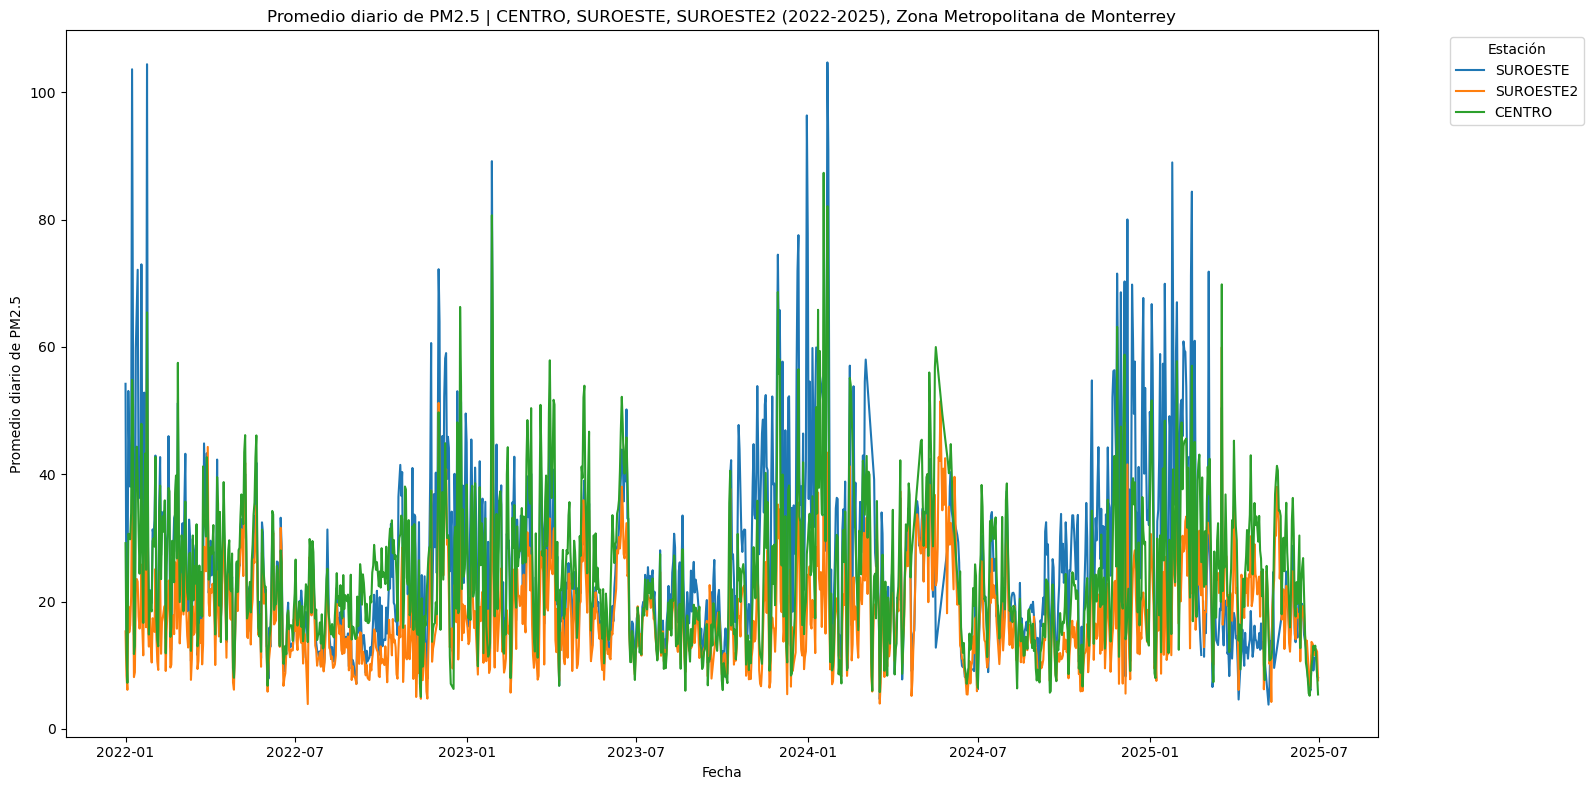

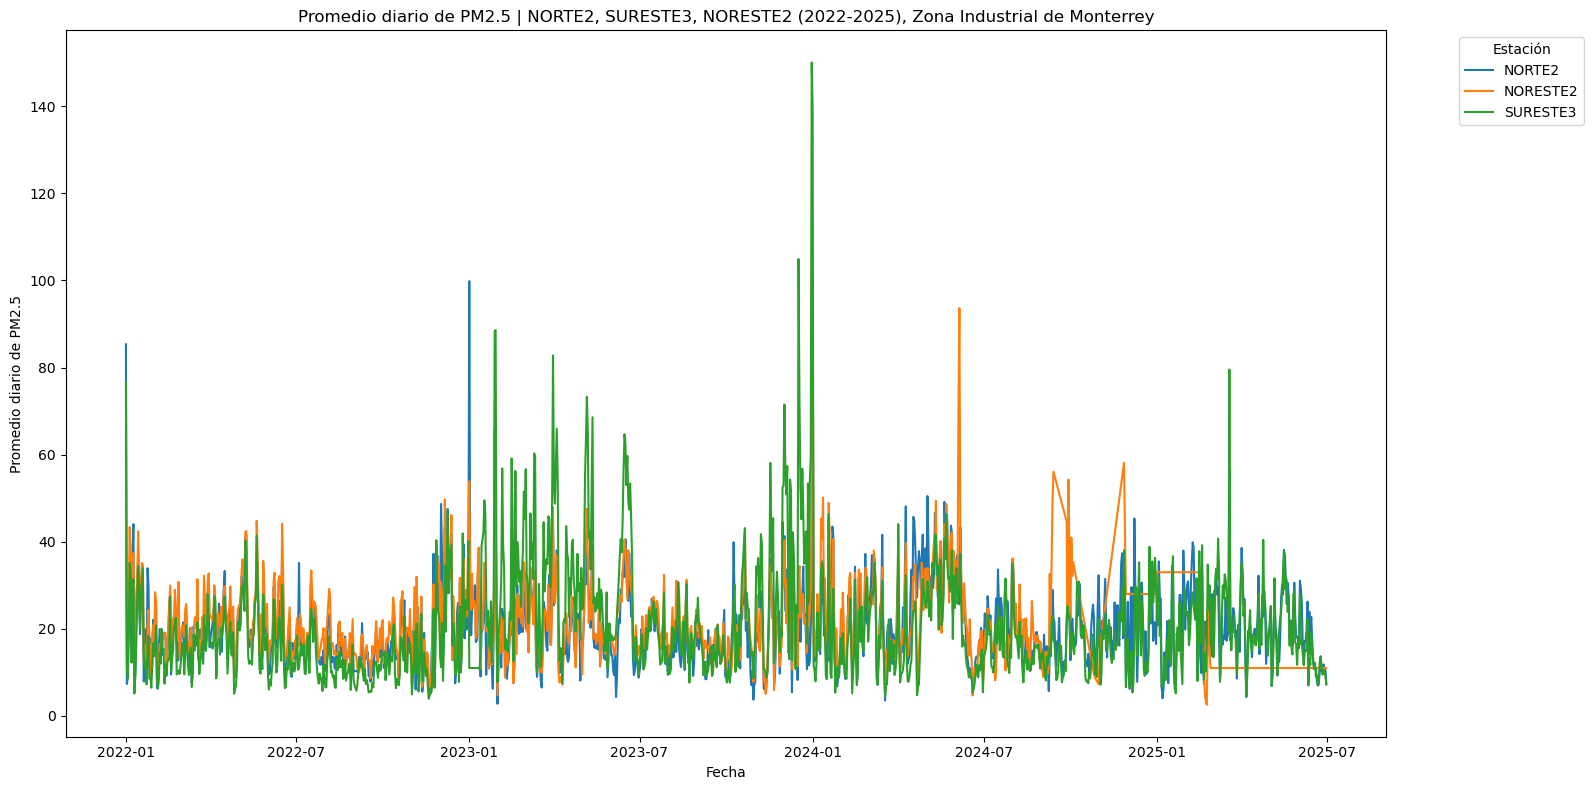

In [59]:

contaminante = "PM2.5"

estaciones1 = [ "SUROESTE", "SUROESTE2", "CENTRO"]
plt.figure(figsize=(16, 8))
for estacion in estaciones1:
    df_est = df_22_25_by_station[estacion].copy()
    df_est.index = pd.to_datetime(df_est.index)
    conta_col = [col for col in df_est.columns if col.upper() == contaminante]
    if conta_col:
        conta_diario = df_est[conta_col[0]].resample("D").mean()
        plt.plot(
            conta_diario.index, conta_diario.values,
            label=estacion
        )
plt.title(f'Promedio diario de {contaminante} | CENTRO, SUROESTE, SUROESTE2 (2022-2025), Zona Metropolitana de Monterrey')
plt.xlabel('Fecha')
plt.ylabel(f'Promedio diario de {contaminante}')
plt.legend(title="Estación", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


estaciones2 = ["NORTE2", "NORESTE2", "SURESTE3"]
plt.figure(figsize=(16, 8))
for estacion in estaciones2:
    df_est = df_22_25_by_station[estacion].copy()
    df_est.index = pd.to_datetime(df_est.index)
    conta_col = [col for col in df_est.columns if col.upper() == contaminante]
    if conta_col:
        conta_diario = df_est[conta_col[0]].resample("D").mean()
        plt.plot(
            conta_diario.index, conta_diario.values,
            label=estacion
        )
plt.title(f'Promedio diario de {contaminante} | NORTE2, SURESTE3, NORESTE2 (2022-2025), Zona Industrial de Monterrey')
plt.xlabel('Fecha')
plt.ylabel(f'Promedio diario de {contaminante}')
plt.legend(title="Estación", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Análisis - CENTRO

In [56]:
df = df_CENTRO_22_25.copy()
df.index = pd.to_datetime(df.index)

print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nRango temporal:", df.index.min(), "→", df.index.max())
df.info()
df.describe().T

Shape: (30646, 11)

Columnas: ['CO', 'NO', 'NO2', 'O3', 'PM10', 'PM2.5', 'PRS', 'RH', 'SO2', 'SR', 'TOUT']

Rango temporal: 2022-01-01 00:00:00 → 2025-06-30 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30646 entries, 2022-01-01 00:00:00 to 2025-06-30 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      30646 non-null  float64
 1   NO      30646 non-null  float64
 2   NO2     30646 non-null  float64
 3   O3      30646 non-null  float64
 4   PM10    30646 non-null  float64
 5   PM2.5   30646 non-null  float64
 6   PRS     30646 non-null  float64
 7   RH      30646 non-null  float64
 8   SO2     30646 non-null  float64
 9   SR      30646 non-null  float64
 10  TOUT    30646 non-null  float64
dtypes: float64(11)
memory usage: 2.8 MB


,count,mean,std,min,25%,50%,75%,max
CO,30646.0,1.579748,0.773366,0.05,1.00,1.44,2.08,5.63
NO,30646.0,9.039951,13.351785,0.50,2.60,3.90,9.70,288.40
NO2,30646.0,16.997454,11.214317,0.00,8.30,14.50,22.90,97.90
O3,30646.0,28.350209,20.315991,1.00,12.00,24.00,39.00,166.00
PM10,30646.0,61.026239,34.093114,2.00,39.00,53.00,74.00,735.00
PM2.5,30646.0,24.728120,15.021518,2.00,13.96,21.36,32.08,246.93
PRS,30646.0,711.363277,3.666050,682.40,709.10,711.10,713.50,726.00
RH,30646.0,54.336793,20.809648,1.00,38.00,56.00,71.00,94.00
SO2,30646.0,4.665761,2.732116,0.50,3.00,4.20,5.60,85.80
SR,30646.0,0.183108,0.279082,0.00,0.00,0.01,0.30,1.25


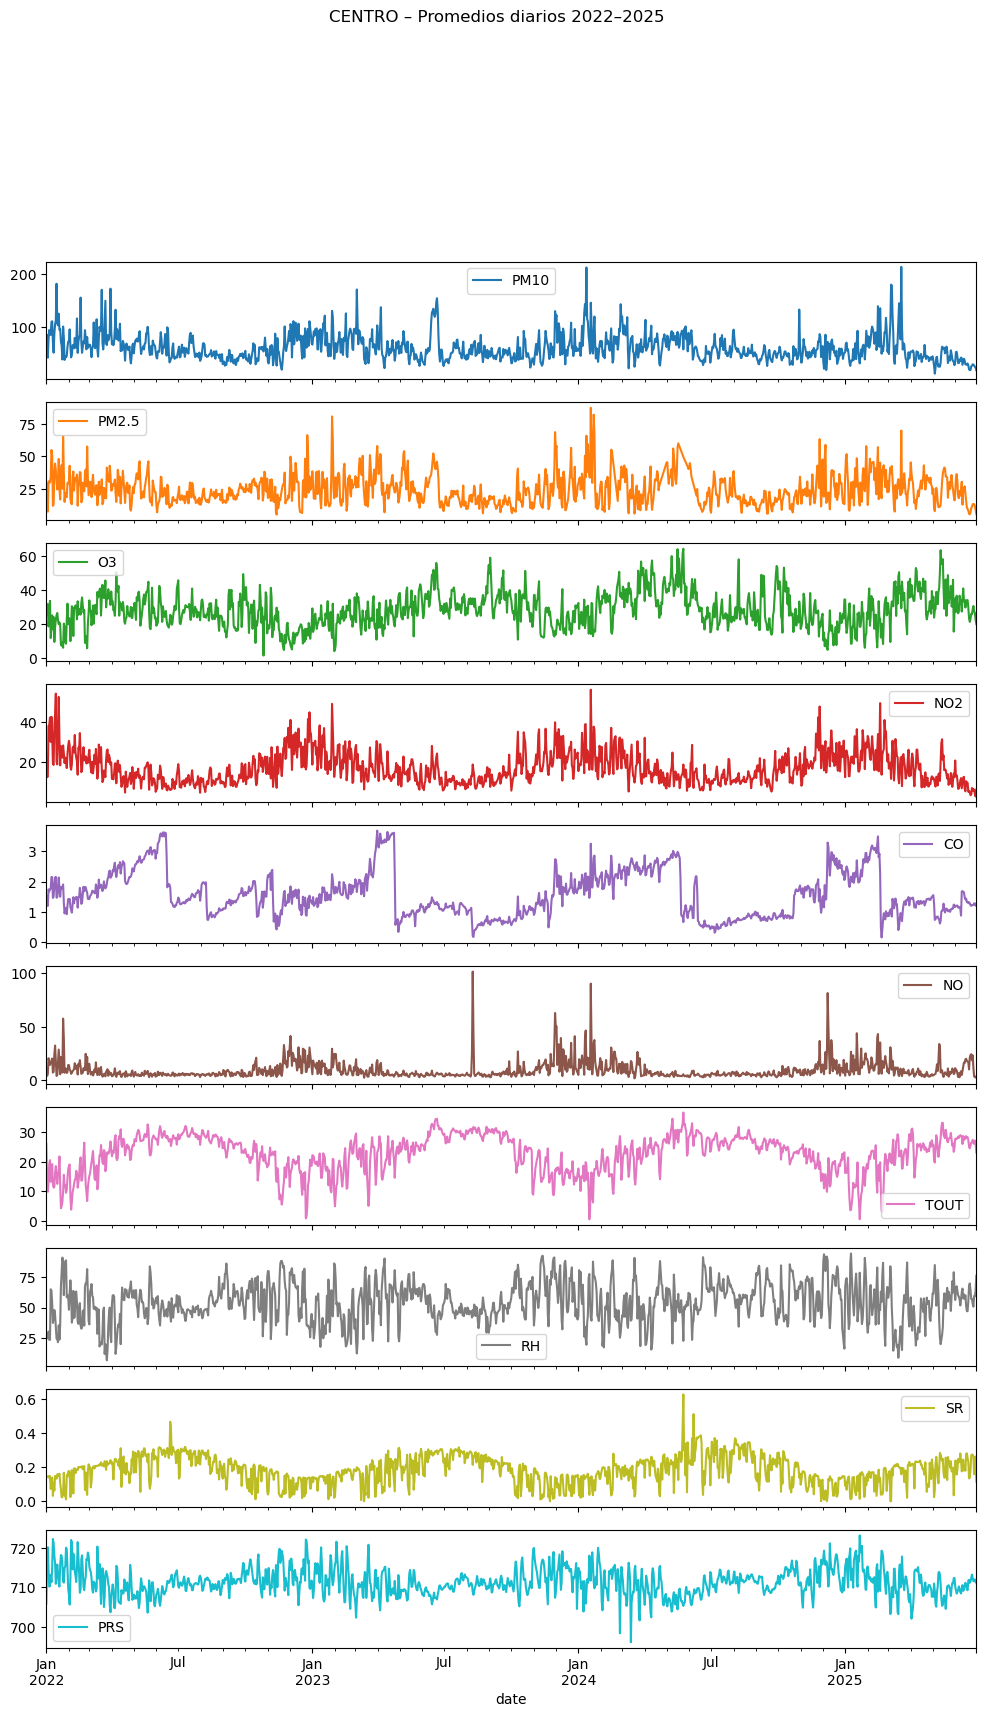

,PM10,PM2.5,O3,NO2,CO,NO,TOUT,RH,SR,PRS
PM10,1.000000,0.613924,0.076726,0.457462,0.269537,0.339802,0.015279,-0.228583,0.231324,-0.147565
PM2.5,0.613924,1.000000,-0.031949,0.494039,0.367352,0.384621,-0.065393,0.072683,0.117888,-0.163233
O3,0.076726,-0.031949,1.000000,-0.295509,-0.088036,-0.297683,0.532095,-0.598938,0.583778,-0.227252
NO2,0.457462,0.494039,-0.295509,1.000000,0.320608,0.528673,-0.332101,0.010195,-0.021683,0.086457
CO,0.269537,0.367352,-0.088036,0.320608,1.000000,0.274172,-0.150365,0.041535,-0.017345,-0.106605
NO,0.339802,0.384621,-0.297683,0.528673,0.274172,1.000000,-0.252687,0.120539,-0.003159,0.077362
TOUT,0.015279,-0.065393,0.532095,-0.332101,-0.150365,-0.252687,1.000000,-0.439681,0.425029,-0.620303
RH,-0.228583,0.072683,-0.598938,0.010195,0.041535,0.120539,-0.439681,1.000000,-0.393316,0.196571
SR,0.231324,0.117888,0.583778,-0.021683,-0.017345,-0.003159,0.425029,-0.393316,1.000000,-0.102105
PRS,-0.147565,-0.163233,-0.227252,0.086457,-0.106605,0.077362,-0.620303,0.196571,-0.102105,1.000000


In [57]:
cols_to_plot = ['PM10', 'PM2.5', 'O3','NO2','CO', 'NO','TOUT','RH','SR','PRS']
df[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle("CENTRO – Promedios diarios 2022–2025", y=1.02)
plt.show()

# Correlaciones básicas
corr = df.corr()
corr.loc[cols_to_plot, cols_to_plot]

### Matriz de correlación

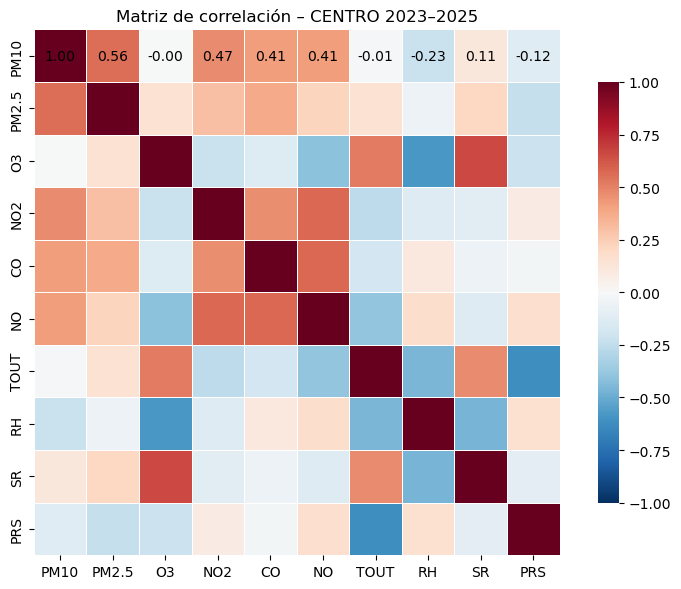

In [16]:
corr_subset = df[cols_to_plot].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_subset,
    annot=True,        
    fmt=".2f",         
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"color": "black", "fontsize": 10}  
)
plt.title("Matriz de correlación – CENTRO 2023–2025")
plt.tight_layout()
plt.show()

### PCA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Matriz de varianza-covarianza:
 [[ 2.01919e+03  3.93250e+02 -2.59000e+00  1.98000e+01  2.73200e+02
   1.03400e+01 -2.63000e+00 -2.12170e+02  8.90000e-01 -2.27100e+01]
 [ 3.93250e+02  2.42770e+02  4.13700e+01  5.92000e+00  6.03200e+01
   3.31000e+00  1.77100e+01 -1.99900e+01  5.80000e-01 -1.52000e+01]
 [-2.59000e+00  4.13700e+01  3.09240e+02  5.78000e+00 -4.99300e+01
  -1.36000e+00  6.76200e+01 -2.14170e+02  2.07000e+00 -1.52900e+01]
 [ 1.98000e+01  5.92000e+00  5.78000e+00  6.12000e+00  4.47000e+00
   1.30000e-01  1.27000e+00 -1.05100e+01  7.00000e-02 -3.80000e-01]
 [ 2.73200e+02  6.03200e+01 -4.99300e+01  4.47000e+00  1.67780e+02
   3.32000e+00 -2.53700e+01 -3.43800e+01 -2.70000e-01  4.35000e+00]
 [ 1.03400e+01  3.31000e+00 -1.36000e+00  1

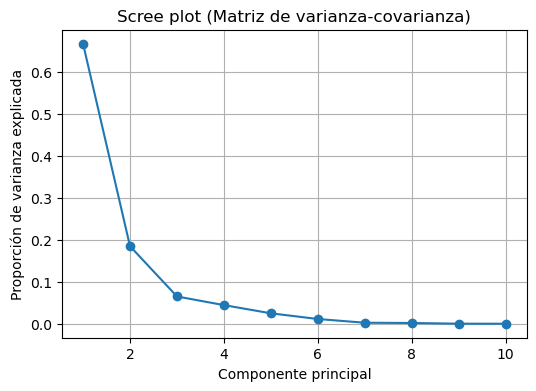

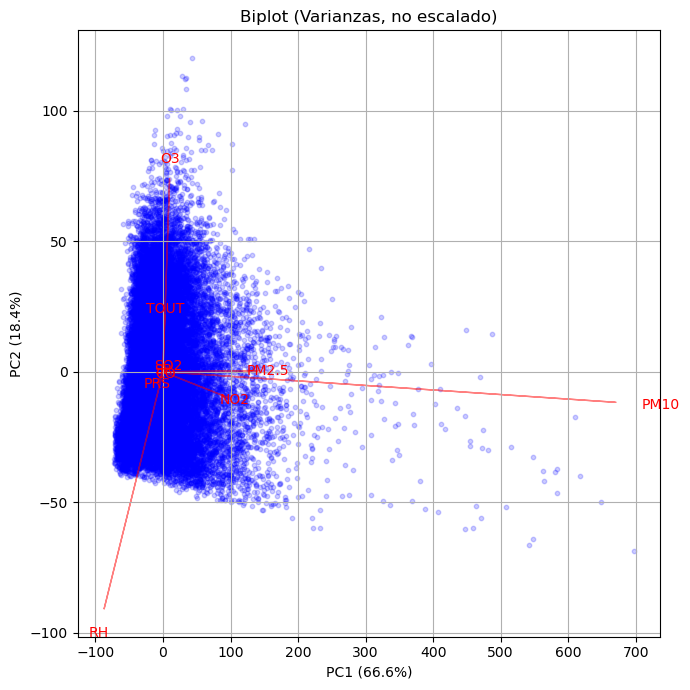

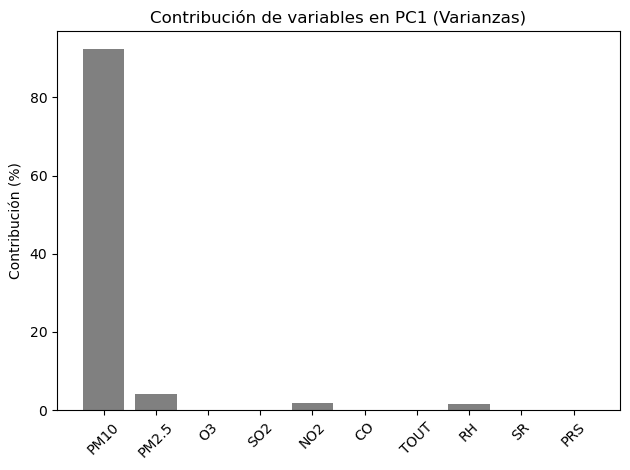

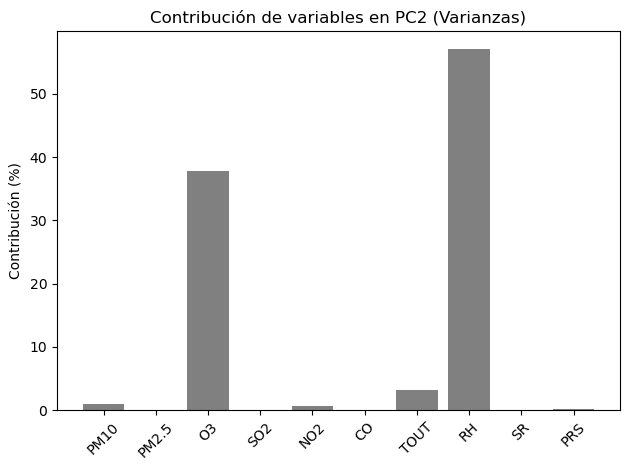

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Matriz de correlación:
 [[ 1.    0.56 -0.    0.18  0.47  0.41 -0.01 -0.23  0.11 -0.12]
 [ 0.56  1.    0.15  0.15  0.3   0.38  0.15 -0.06  0.21 -0.24]
 [-0.    0.15  1.    0.13 -0.22 -0.14  0.52 -0.58  0.66 -0.21]
 [ 0.18  0.15  0.13  1.    0.14  0.09  0.07 -0.2   0.15 -0.04]
 [ 0.47  0.3  -0.22  0.14  1.    0.46 -0.26 -0.13 -0.12  0.08]
 [ 0.41  0.38 -0.14  0.09  0.46  1.   -0.18  0.1  -0.06 -0.02]
 [-0.01  0.15  0.52  0.07 -0.26 -0.18  1.   -0.46  0.47 -0.62]
 [-0.23 -0.06 -0.58 -0.2  -0.13  0.1  -0.46  1.   -0.47  0.16]
 [ 0.11  0.21  0.66  0.15 -0.12 -0.06  0.47 -0.47  1.   -0.11]
 [-0.12 -0.24 -0.21 -0.04  0.08 -0.02 -0.62  0.16 -0.11  1.  ]]


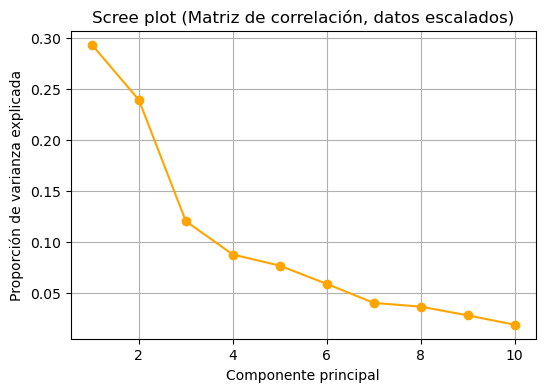

/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


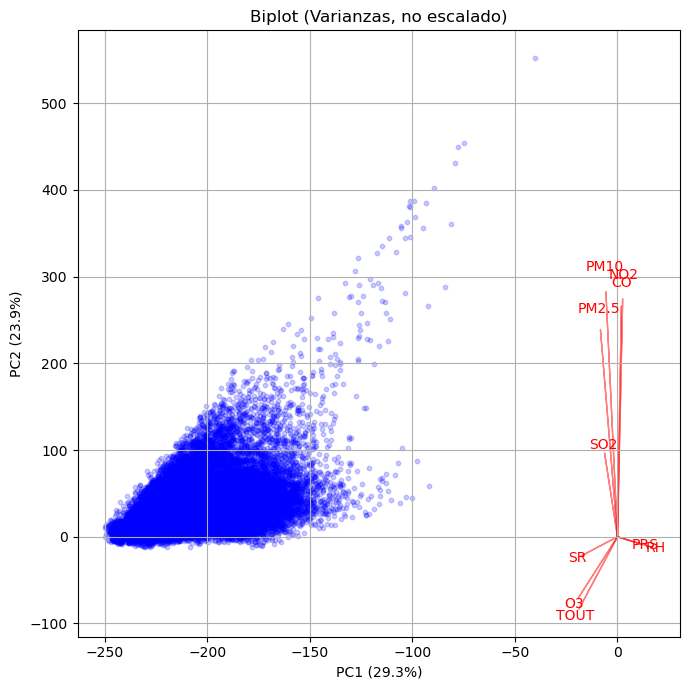

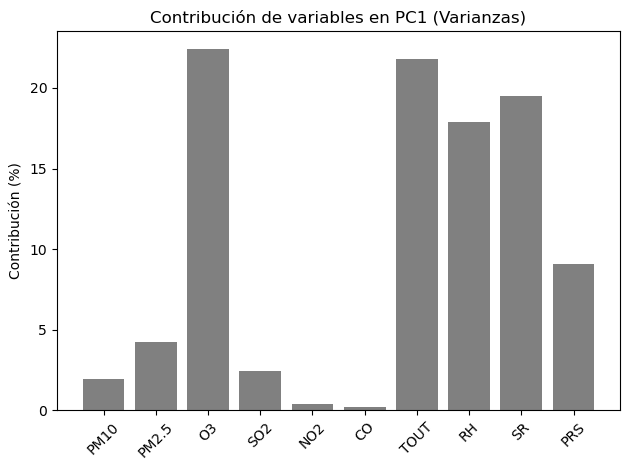

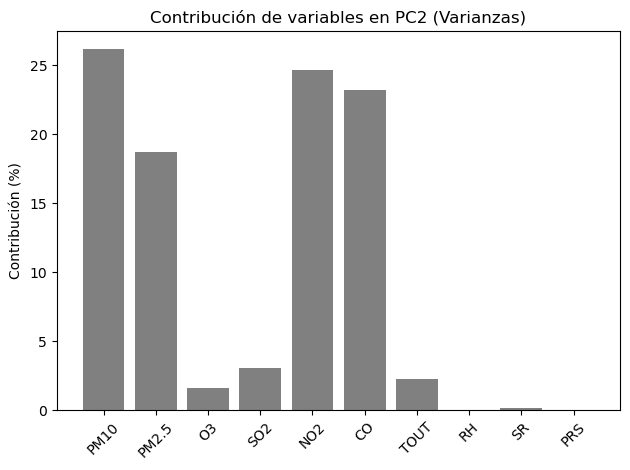

In [17]:
cols_pca = ['PM10', 'PM2.5', 'O3', 'SO2','NO2','CO','TOUT','RH','SR','PRS']

X = df[cols_pca].dropna()

# 1. Matriz de Varianza-Covarianza
cov_matrix = np.cov(X.values, rowvar=False)
print("Matriz de varianza-covarianza:\n", np.round(cov_matrix, 2))

# 2. Valores y vectores propios (autovalores y autovectores)
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
# Ordenar de mayor a menor
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

print("\nValores propios:\n", np.round(eig_vals, 2))
print("\nVectores propios (columnas):\n", np.round(eig_vecs, 2))

# 3. Proporción de varianza explicada
explained_var_ratio = eig_vals / np.sum(eig_vals)
print("\nProporción de varianza explicada:\n", np.round(explained_var_ratio, 3))

# 4. Varianza acumulada
cumulative_var_ratio = np.cumsum(explained_var_ratio)
print("\nVarianza acumulada por componente:\n", np.round(cumulative_var_ratio, 3))

# 5. Gráficas de PCA (sobre matriz de varianzas/covarianzas, sin escalado)
pca_cov = PCA(n_components=len(cols_pca), svd_solver='full')
pca_cov.fit(X)

# Scree plot (varianza explicada por componente)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cols_pca)+1), pca_cov.explained_variance_ratio_, marker='o')
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.title('Scree plot (Matriz de varianza-covarianza)')
plt.grid(True)
plt.show()

# Biplot - proyección de los individuos y las variables
def pca_biplot(pca, x_pc=1, y_pc=2, labels=None, color="blue"):
    X_reduced = pca.transform(X)
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(X_reduced[:, x_pc-1], X_reduced[:, y_pc-1], alpha=0.2, color=color, s=10)
    for i, var in enumerate(cols_pca):
        ax.arrow(0, 0, 
                 pca.components_[x_pc-1, i]*max(X_reduced[:, x_pc-1]),
                 pca.components_[y_pc-1, i]*max(X_reduced[:, y_pc-1]),
                 color="red", width=0.002, head_width=0.08, alpha=0.5)
        ax.text(pca.components_[x_pc-1, i]*max(X_reduced[:, x_pc-1])*1.1,
                pca.components_[y_pc-1, i]*max(X_reduced[:, y_pc-1])*1.1,
                var, color='red', ha='center', va='center')
    ax.set_xlabel(f'PC{x_pc} ({pca.explained_variance_ratio_[x_pc-1]*100:.1f}%)')
    ax.set_ylabel(f'PC{y_pc} ({pca.explained_variance_ratio_[y_pc-1]*100:.1f}%)')
    ax.set_title("Biplot (Varianzas, no escalado)")
    plt.grid()
    plt.tight_layout()
    plt.show()

pca_biplot(pca_cov, 1, 2)

# Contribución de cada variable en PC1 y PC2
def plot_var_contrib(pca, pc=1):
    contrib = np.square(pca.components_[pc-1])
    contrib = contrib/np.sum(contrib) * 100  # porcentaje
    plt.bar(cols_pca, contrib, color="gray")
    plt.ylabel('Contribución (%)')
    plt.title(f'Contribución de variables en PC{pc} (Varianzas)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_var_contrib(pca_cov, 1)
plot_var_contrib(pca_cov, 2)

# --- Repetir análisis escalando los datos (matriz de correlación) ---

X_scaled = StandardScaler().fit_transform(X)

# Matriz de correlación
corr_matrix = np.corrcoef(X_scaled, rowvar=False)
print("\nMatriz de correlación:\n", np.round(corr_matrix, 2))

# PCA sobre matriz de correlaciones (datos estándar: media 0, var 1)
pca_corr = PCA(n_components=len(cols_pca))
pca_corr.fit(X_scaled)

# Scree plot (matriz de correlación)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cols_pca)+1), pca_corr.explained_variance_ratio_, marker='o', color="orange")
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.title('Scree plot (Matriz de correlación, datos escalados)')
plt.grid(True)
plt.show()

# Biplot de PCA (sobre datos estandarizados)
pca_biplot(pca_corr, 1, 2)

# Contribución de variables en PC1 y PC2 (matriz de correlación)
plot_var_contrib(pca_corr, 1)
plot_var_contrib(pca_corr, 2)


### Box Plot

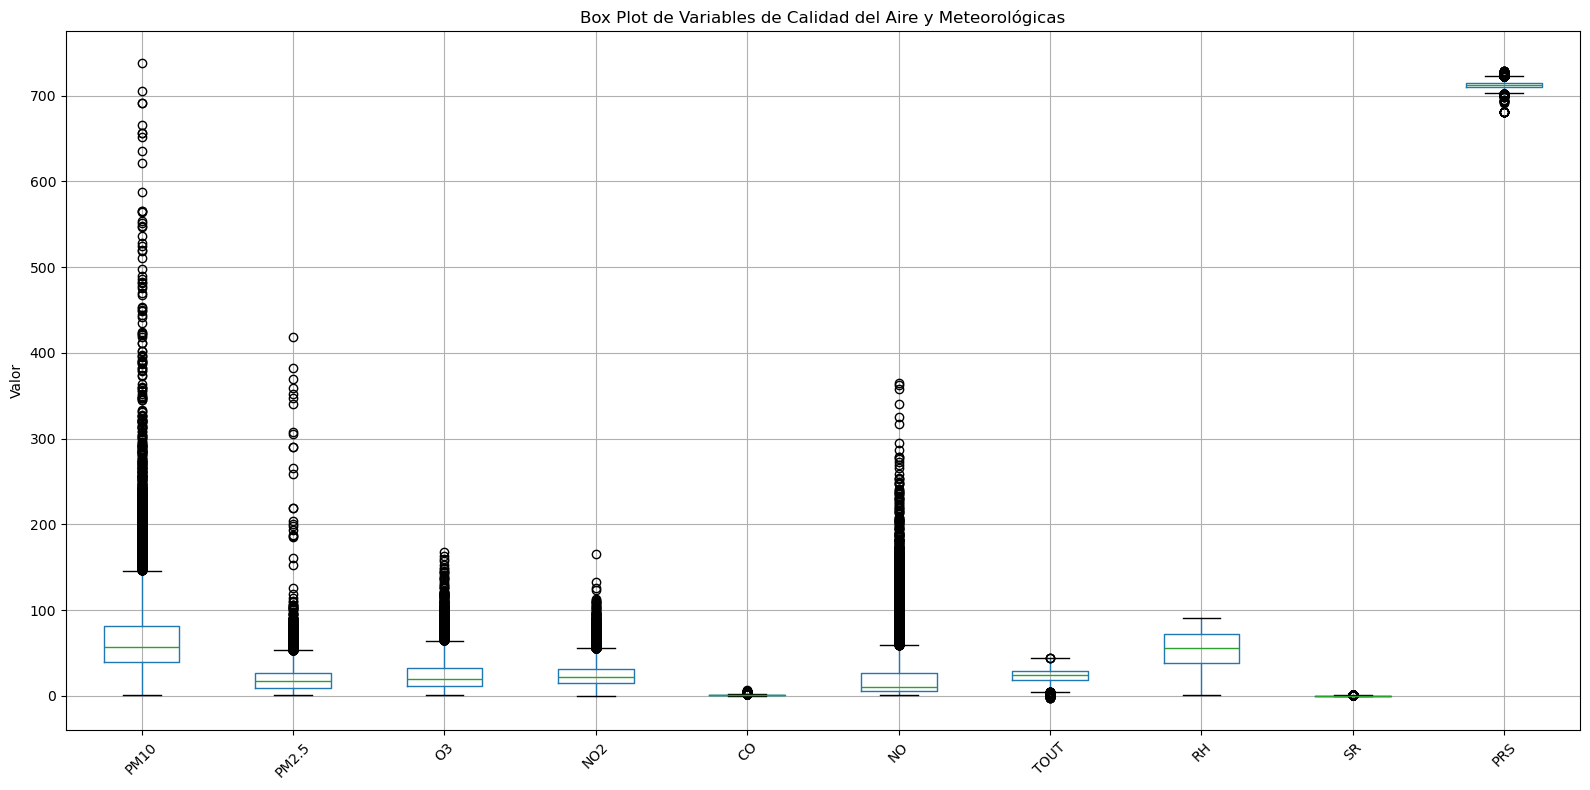

In [18]:
plt.figure(figsize=(16, 8))
df[cols_to_plot].boxplot()
plt.title("Box Plot de Variables de Calidad del Aire y Meteorológicas")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

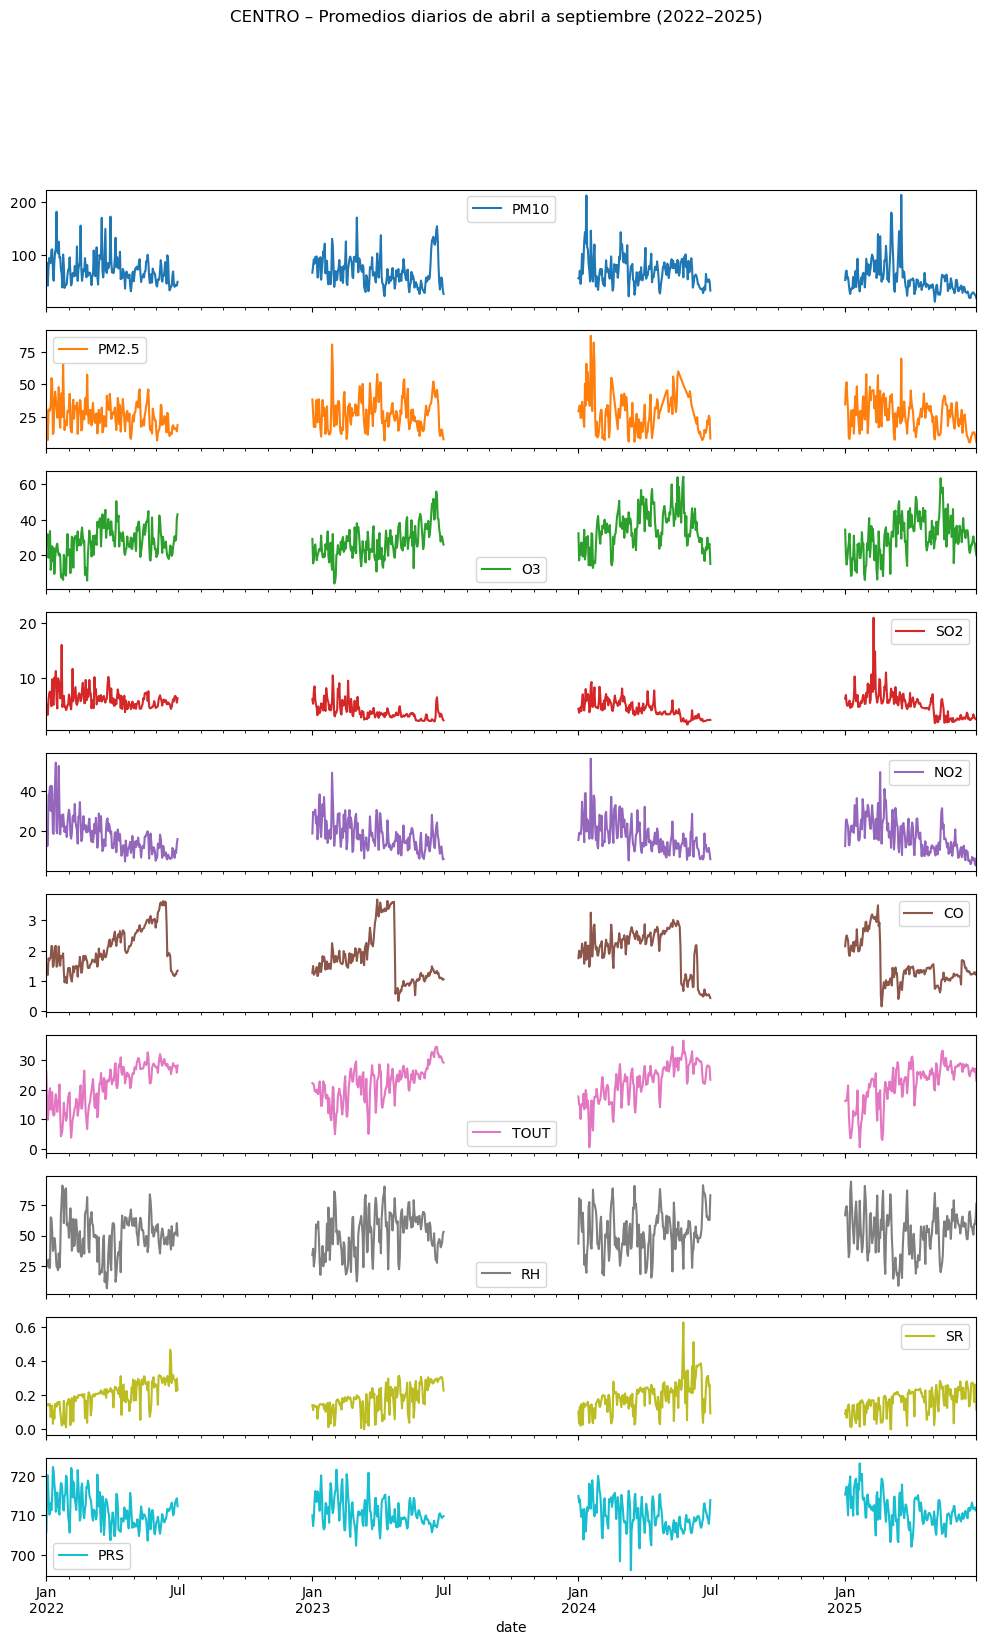

In [22]:
# Extraer solo los datos entre abril y septiembre de cada año
df_periodo = df[(df.index.month >= 1) & (df.index.month <= 6)]

df_periodo[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle("CENTRO – Promedios diarios de abril a septiembre (2022–2025)")
plt.show()


## Análisis - SUROESTE

## Análisis - NORTE

## Análisis - SUROESTE2

## Análisis - SURESTE3

## Análisis - NORESTE2